In [1]:
#from keras import backend as K
#K.clear_session()

In [1]:
# Python ≥3.5 is required
import sys

assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= '0.20'

from sklearn.impute import SimpleImputer
#from sklearn.pipeline import Pipelines
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

# TensorFlow ≥2.0 is required
import tensorflow_addons as tfa
import tensorflow as tf
assert tf.__version__ >= '2.0'

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model

from keras.models import Sequential
#from keras.layers.wrappers import TimeDistributed
#from keras.layers import Dense,LSTM,Conv2D, BatchNormalization,Flatten, MaxPooling2D
#from keras.layers import Conv2DTranspose,Concatenate,UpSampling2D,Cropping2D
#from keras.layers import Input, Lambda, Reshape, Dropout, Activation

from tensorflow.keras.layers import Dropout, BatchNormalization, Reshape
from tensorflow.keras.layers import Dense, Conv2D, Input, MaxPooling2D, Flatten, MaxPool2D, MaxPool3D, UpSampling2D
from tensorflow.keras.layers import Conv2DTranspose, Flatten, Reshape, Cropping2D, Embedding, BatchNormalization,ZeroPadding2D
from tensorflow.keras.layers import LeakyReLU, Activation, Input, add, multiply
from tensorflow.keras.layers import concatenate, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import Lambda
import tensorflow.keras.backend as K

#print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Common imports
import os
import glob
import numpy as np
import pandas as pd
import geopandas as gpd
import xarray as xr
import dask
import datetime
import math
import pathlib
import hashlib
dask.config.set({'array.slicing.split_large_chunks': False})

# To make this notebook's output stable across runs
np.random.seed(42)

# Config matplotlib
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt


mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
# Dotenv
from dotenv import dotenv_values
# Custom utils
from utils.utils_data import *
from utils.utils_ml import *
from utils.utils_plot import *
from utils.utils_unet import *
from utils.utils_resnet import *

In [2]:
# Define paths
config = dotenv_values(".env")
PATH_ERA5 = config['PATH_ERA5']
PATH_EOBS = config['PATH_EOBS']


In [3]:
# Some constants
DATE_START = '1979-01-01'
DATE_END = '2021-12-31'
# train -test (80/20 of total yy), train-> split 80/20 for validation
#YY_TRAIN = [1979, 2011] # 2005-2011 for validation
#YY_VAL = [2005,2011]
#YY_TEST = [2012, 2020]
YY_TRAIN = [1979, 2015]
YY_TEST = [2016, 2021]
YY_VALID = 2005
LEVELS = [500, 850, 1000]
G = 9.80665 
LONS_INPUT = [-25, 30]
LATS_INPUT = [30, 75]
LONS_PREC = [-25, 30]
LATS_PREC = [30, 75]

PRECIP_DATA = 'ERA5' # Options: ERA5, E-OBS
PRECIP_XTRM = 0.95 # Percentile (threshold) for the extremes

In [4]:
# Load precipitation
if PRECIP_DATA == 'ERA5':
    pr = get_nc_data(PATH_ERA5 + '/precipitation/day_grid1/*nc', DATE_START, DATE_END, LONS_PREC, LATS_PREC)
    pr = pr.tp
elif PRECIP_DATA in ['E-OBS', 'EOBS']:
    pr = get_nc_data(PATH_EOBS + '/*nc', DATE_START, DATE_END, LONS_PREC, LATS_PREC)
    pr = pr.rr
    pr = pr.coarsen(lon=5, lat=5, boundary="trim").mean()
    pr = pr.fillna(0) # Over the seas. Not optimal...
else:
    raise('Precipitation data not well defined')

Extracting data for the period 1979-01-01 - 2021-12-31


In [5]:
# Define extremes
pr95 = precip_exceedance_xarray(pr, PRECIP_XTRM)

In [6]:
# Extract coordinates for precip
lats_y = pr.lat.to_numpy()
lons_y = pr.lon.to_numpy()

In [7]:
# define paths for the variables used
l_paths = ['/geopotential/day_grid1/','/temperature/day_grid1/','/relative_humidity/day_grid1/',
              '/U_wind/day_grid1/','/V_wind/day_grid1/','/total_column_water/day_grid1/']
v_vars = ['z','t2m','rh','u850','v850','tpcw']
list_vars = load_data(v_vars, l_paths, G, PATH_ERA5, DATE_START, DATE_END, LONS_INPUT, LATS_INPUT, LEVELS)
datasets = list_vars

Extracting data for the period 1979-01-01 - 2021-12-31
Extracting data for the period 1979-01-01 - 2021-12-31
Extracting data for the period 1979-01-01 - 2021-12-31
Extracting data for the period 1979-01-01 - 2021-12-31
Extracting data for the period 1979-01-01 - 2021-12-31
Extracting data for the period 1979-01-01 - 2021-12-31


In [15]:
dic = {
     'z': LEVELS,
      't': LEVELS,
      'r': LEVELS,
      'u': LEVELS,
      'v': LEVELS,
      'tcwv':None}
# Check if all have the same latitude order
for idat in range(0, len(datasets)):
    # Invert lat axis if needed
    if datasets[idat].lat[0].values < datasets[idat].lat[1].values:
        print('change lat order', idat)
        datasets[idat] = datasets[idat].reindex(lat=list(reversed(datasets[idat].lat)))

In [16]:
ds = xr.merge(datasets)

In [17]:
BATCH_SIZE=64 # try increase, decrease it

In [18]:
# Split into training and test, then I will use DataGenerator class to get the validation
ds_train = ds.sel(time=slice('{}-01-01'.format(YY_TRAIN[0]),
                             '{}-12-31'.format(YY_TRAIN[1])))
ds_test = ds.sel(time=slice('{}-01-01'.format(YY_TEST[0]),
                            '{}-12-31'.format(YY_TEST[1])))

dy_train = pr95.sel(time=slice('{}-01-01'.format(YY_TRAIN[0]),
                             '{}-12-31'.format(YY_TRAIN[1])))
dy_test = pr95.sel(time=slice('{}-01-01'.format(YY_TEST[0]),
                             '{}-12-31'.format(YY_TEST[1])))

In [19]:
dy_pr_train = pr.sel(time=slice('{}-01-01'.format(YY_TRAIN[0]),
                             '{}-12-31'.format(YY_TRAIN[1])))
dy_pr_test = pr.sel(time=slice('{}-01-01'.format(YY_TEST[0]),
                             '{}-12-31'.format(YY_TEST[1])))

In [20]:
dg_train = DataGeneratorWithExtremes(ds_train.sel(time=slice(f'{YY_TRAIN[0]}', f'{YY_VALID}')),
                                     dy_pr_train.sel(time=slice(f'{YY_TRAIN[0]}', f'{YY_VALID}')),
                                     dy_train.sel(time=slice(f'{YY_TRAIN[0]}', f'{YY_VALID}')),
                                     dic, batch_size=BATCH_SIZE, load=True)
dg_valid = DataGeneratorWithExtremes(ds_train.sel(time=slice(f'{YY_VALID+1}', f'{YY_TRAIN[1]}')),
                                     dy_pr_train.sel(time=slice(f'{YY_VALID+1}', f'{YY_TRAIN[1]}')),
                                     dy_train.sel(time=slice(f'{YY_VALID+1}', f'{YY_TRAIN[1]}')),
                                     dic, mean=dg_train.mean, std=dg_train.std,
                                     batch_size=BATCH_SIZE, load=True)
dg_test = DataGeneratorWithExtremes(ds_test, dy_pr_test, dy_test, dic,
                                    mean=dg_train.mean, std=dg_train.std,
                                    batch_size=BATCH_SIZE, load=True, shuffle=False)

/storage/homefs/no21h426/.local/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


Loading data into RAM
Loading data into RAM
Loading data into RAM


In [18]:
#for now I am going to use extremes:
# Switch to precipitation extremes
dg_train.for_extremes(True)
dg_valid.for_extremes(True)
dg_test.for_extremes(True)

In [19]:
ds_test.to_netcdf('tmp/data/ds_test.nc')

In [20]:
# save data test 
dg_test.X.to_netcdf('tmp/data/dg_test_X.nc') # predictors
dg_test.y.to_netcdf('tmp/data/dg_test_Y.nc') # predictand
dg_test.y_xtrm.to_netcdf('tmp/data/dg_test_Y_xtrm.nc')

In [16]:
# Create a training and validation data generator. Use the train mean and std for validation as well.
#dg_train = MyDataGenerator(ds_train.sel(time=slice(f'{YY_TRAIN[0]}', f'{YY_VALID}')),
#                                dy_train.sel(time=slice(f'{YY_TRAIN[0]}', f'{YY_VALID}')), dic, batch_size= BATCH_SIZE, load=True)
# Create a validation. Use the train mean and std for validation as well. And suffle
#dg_val = MyDataGenerator(ds_train.sel(time=slice(f'{YY_VALID}', f'{YY_TRAIN[1]}')),
#                                dy_train.sel(time=slice(f'{YY_VALID}', f'{YY_TRAIN[1]}')), dic, batch_size=BATCH_SIZE,  mean=dg_train.mean, std=dg_train.std, load=True)
# Now also a generator for testing. Impartant: Shuffle must be False!
#dg_test = MyDataGenerator(ds_test, dy_test, dic, batch_size=BATCH_SIZE, mean=dg_train.mean, std=dg_train.std, shuffle=False)

### Setting-up

In [16]:

# Define args for the U-net model
i_shape = dg_train.X.shape[1:]
o_shape = dg_train.y_xtrm.shape[1:]

print(f'X shape: {i_shape}')
print(f'y shape: {o_shape}')
output_channels = 1
num_filters = 32
use_batchnorm = True
dropout = True
lr = 0.0004
optimizer = tf.optimizers.Adam(learning_rate = lr)
EPOCHS = 50

X shape: (46, 56, 10)
y shape: (46, 56)


In [17]:
METRICS = [
    tf.metrics.CategoricalAccuracy(name='accuracy'),
    tf.metrics.Precision(class_id = 1, name='precision'),
    tf.metrics.Recall(class_id = 1, name='recall')
]

2022-04-11 10:30:03.836269: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-11 10:30:07.634820: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10415 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:04:00.0, compute capability: 6.1


In [18]:
weights = class_weight.compute_class_weight('balanced', classes = np.unique(dg_train.y_xtrm), y = np.array(dg_train.y_xtrm).flatten())

In [19]:
model_loss = weighted_binary_cross_entropy(weights = {0: weights[0].astype('float32'), 1: weights[1].astype('float32')})

### Set a list of models
#### U-Net, att-unet and unet-convlstm 

In [20]:
names_mod = ['unet','unet-att','unet-convlstm']
#names_mod = ['unet']
l_mod = []
# note: I removed batchnormalization, still trying to improve this

modeling unet
Epoch 1/50


2022-04-11 10:30:21.106848: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8201


154/154 [==============================] - 39s 135ms/step - loss: 0.3700 - accuracy: 0.0891 - precision: 0.1693 - recall: 0.8846 - val_loss: 0.3027 - val_accuracy: 0.1125 - val_precision: 0.1909 - val_recall: 0.9562
Epoch 2/50
154/154 [==============================] - 20s 127ms/step - loss: 0.2920 - accuracy: 0.1078 - precision: 0.2130 - recall: 0.9184 - val_loss: 0.2749 - val_accuracy: 0.1061 - val_precision: 0.2079 - val_recall: 0.9610
Epoch 3/50
154/154 [==============================] - 20s 128ms/step - loss: 0.2707 - accuracy: 0.1099 - precision: 0.2318 - recall: 0.9273 - val_loss: 0.2549 - val_accuracy: 0.1312 - val_precision: 0.2573 - val_recall: 0.9395
Epoch 4/50
154/154 [==============================] - 20s 128ms/step - loss: 0.2564 - accuracy: 0.1143 - precision: 0.2455 - recall: 0.9303 - val_loss: 0.2431 - val_accuracy: 0.1243 - val_precision: 0.2704 - val_recall: 0.9432
Epoch 5/50
154/154 [==============================] - 20s 128ms/step - loss: 0.2463 - accuracy: 0.1146 

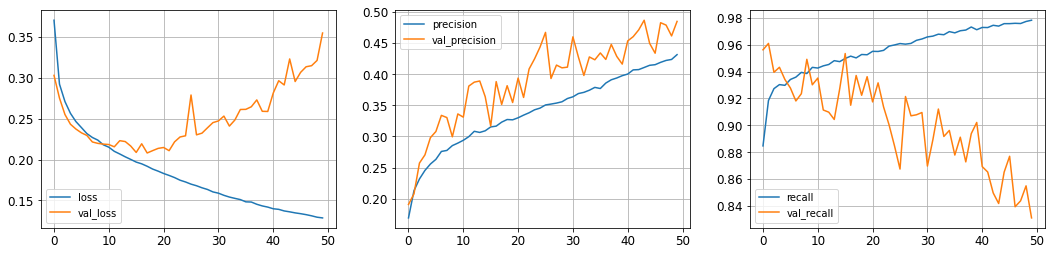

2022-04-11 10:47:27.606885: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: tmp/unet/assets
modeling unet-att
Epoch 1/50
154/154 [==============================] - 8s 38ms/step - loss: 0.3465 - accuracy: 0.1084 - precision: 0.2090 - recall: 0.8721 - val_loss: 0.2913 - val_accuracy: 0.1184 - val_precision: 0.2112 - val_recall: 0.9158
Epoch 2/50
154/154 [==============================] - 5s 34ms/step - loss: 0.2733 - accuracy: 0.1120 - precision: 0.2179 - recall: 0.9226 - val_loss: 0.2655 - val_accuracy: 0.1250 - val_precision: 0.2122 - val_recall: 0.9514
Epoch 3/50
154/154 [==============================] - 5s 34ms/step - loss: 0.2570 - accuracy: 0.1095 - precision: 0.2359 - recall: 0.9353 - val_loss: 0.2587 - val_accuracy: 0.1145 - val_precision: 0.2506 - val_recall: 0.9381
Epoch 4/50
154/154 [==============================] - 5s 35ms/step - loss: 0.2474 - accuracy: 0.1044 - precision: 0.2450 - recall: 0.9388 - val_loss: 0.2543 - val_accuracy: 0.1072 - val_precision: 0.3016 - val_recall: 0.9196
Epoch 5/50
154/154 [===========

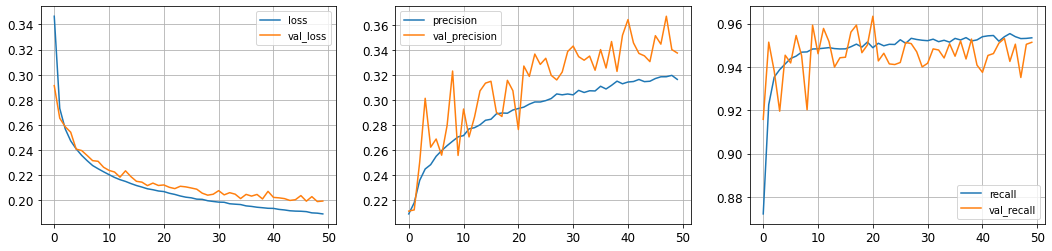

INFO:tensorflow:Assets written to: tmp/unet-att/assets


INFO:tensorflow:Assets written to: tmp/unet-att/assets


modeling unet-convlstm
Epoch 1/50
154/154 [==============================] - 71s 404ms/step - loss: 0.3478 - accuracy: 0.1134 - precision: 0.2012 - recall: 0.9170 - val_loss: 0.3239 - val_accuracy: 0.1075 - val_precision: 0.2527 - val_recall: 0.8415
Epoch 2/50
154/154 [==============================] - 61s 398ms/step - loss: 0.2817 - accuracy: 0.1196 - precision: 0.2235 - recall: 0.9150 - val_loss: 0.3045 - val_accuracy: 0.1205 - val_precision: 0.3191 - val_recall: 0.8538
Epoch 3/50
154/154 [==============================] - 61s 399ms/step - loss: 0.2662 - accuracy: 0.1264 - precision: 0.2410 - recall: 0.9239 - val_loss: 0.2790 - val_accuracy: 0.1444 - val_precision: 0.3067 - val_recall: 0.9086
Epoch 4/50
154/154 [==============================] - 61s 399ms/step - loss: 0.2554 - accuracy: 0.1277 - precision: 0.2529 - recall: 0.9258 - val_loss: 0.2617 - val_accuracy: 0.1378 - val_precision: 0.3134 - val_recall: 0.9066
Epoch 5/50
154/154 [==============================] - 61s 399ms/step 

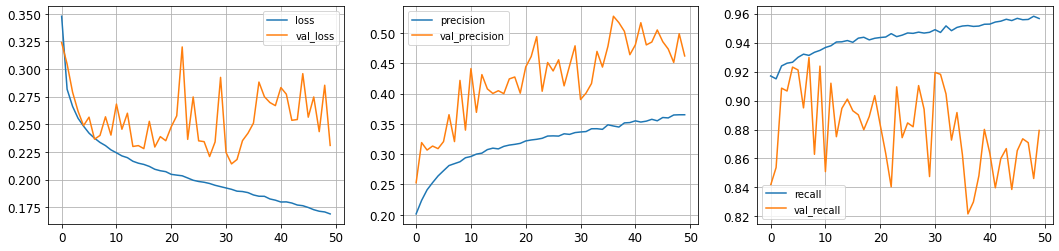

INFO:tensorflow:Assets written to: tmp/unet-convlstm/assets


INFO:tensorflow:Assets written to: tmp/unet-convlstm/assets


In [21]:
for imod in names_mod:
    print('modeling',imod)
    u_mod = Unet2(imod, i_shape, o_shape, output_channels, num_filters, False, dropout)
    
    # Build the model and compile
    if (imod == 'unet'):
        um = u_mod.build_model()
    elif (imod == 'unet-att'):
        um = u_mod.att_unet()
    elif (imod == 'unet-convlstm'):
        um = u_mod.build_UnetConvLSTM()
    # compile     
    um.compile(optimizer =optimizer, loss = model_loss , metrics = METRICS)
    #um.summary()
    h_unet = um.fit(dg_train, epochs=EPOCHS, validation_data= dg_valid)
    
    # plot outputs
    print('plotting model history for',imod)
    figure, axis = plt.subplots(1, 3)

    # For Sine Function
    pd.DataFrame(h_unet.history)[['loss','val_loss']].plot(figsize=(18,4), ax=axis[0], grid=True)
    pd.DataFrame(h_unet.history)[['precision','val_precision']].plot(figsize=(18,4), ax=axis[1],grid=True)
    pd.DataFrame(h_unet.history)[['recall','val_recall']].plot(figsize=(18,4), ax=axis[2],grid=True)
    plt.show()
    
    # save models and weigths (separately)
    tmp_file = pathlib.Path(f'tmp/{imod}')
    um.save(f'tmp/{imod}')
    
    um.save_weights('tmp/tmp_weights/' + imod + '_trained_weights.h5')
    
    
    
    l_mod.append(um)
    
    

In [22]:
for imod in range(0,len(names_mod)):
    print('predicting for',imod)
    
    y_pred_train = l_mod[0].predict(dg_train.X.to_numpy()).squeeze()
    y_pred_test = l_mod[0].predict(dg_test.X.to_numpy()).squeeze()

predicting for 0
predicting for 1
predicting for 2


In [23]:
y_pred_train = l_mod[0].predict(dg_train.X.to_numpy()).squeeze()
y_pred_test = l_mod[0].predict(dg_test.X.to_numpy()).squeeze()

In [25]:
# Multiply to transorm to numeric values
y_pred_bool = y_pred_test >= 0.5
y_pred_bool = y_pred_bool * 1
# Extract true values
y_xtrm = dg_test.y_xtrm.to_numpy().squeeze()
# Get the index of the max # of extremes
i_max_obs = np.argmax(np.sum(y_xtrm, axis=(1,2)))

In [27]:
datemax = dg_test.X.time[i_max_obs]

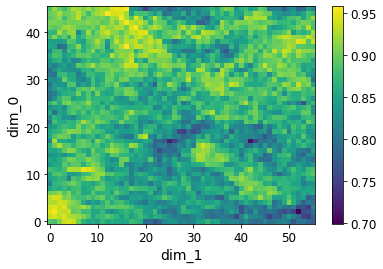

In [29]:
# Compute anther scores
matrix_sedi = score_matrix(dg_test.y_xtrm, y_pred_bool, 'SEDI')
xr.DataArray(matrix_sedi).plot()

In [31]:
#save the test data
PATH_OUT = 'tmp/data/'
os.makedirs(PATH_OUT, exist_ok=True)
dg_test.X.to_netcdf('tmp/dg_test_X.nc')
dg_test.y.to_netcdf('tmp/dg_test_Y.nc')
dg_test.y_xtrm.to_netcdf('tmp/dg_test_Y_xtrm.nc')